# Détection de Fake News
**Objectif :** Ce notebook présente l'ensemble du projet de détection de fake news à partir d'articles, en utilisant des modèles de Machine Learning.  
Nous allons :  
1. Charger et nettoyer les données  
2. Explorer et visualiser les textes  
3. Vectoriser les textes avec TF-IDF  
4. Entraîner et comparer des modèles (Random Forest, XGBoost)  
5. Évaluer les performances et visualiser les résultats

## Importation des bibliothèques

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

# Affichage plus joli
sns.set_style('whitegrid')

## Chargement des données
On charge les données pré-traitées depuis `data/processed/fake_news_processed.csv` et on vérifie les premières lignes.

In [2]:
df = pd.read_csv("../data/processed/fake_news_processed.csv")
print(f"Données initiales : {len(df)} lignes")

# Supprimer les lignes où processed_text est NaN
df = df.dropna(subset=['processed_text'])
print(f"Données après nettoyage : {len(df)} lignes")

df.head()

Données initiales : 44898 lignes
Données après nettoyage : 44182 lignes


,text,label,clean_text,processed_text
0,The Trump administration has been getting abso...,1,the trump administration has been getting abso...,trump administration getting absolutely pummel...
1,NAIROBI (Reuters) - Kenyan police shot dead tw...,0,nairobi reuters kenyan police shot dead two p...,nairobi reuters kenyan police shot dead two pe...
2,PC is killing our country. This is called figh...,1,pc is killing our country this is called fight...,pc killing country called fighting back counte...
3,WASHINGTON (Reuters) - Republicans are poised ...,0,washington reuters republicans are poised to ...,washington reuters republican poised repeal u ...
4,(Reuters) - A U.S. appeals court ruled on Frid...,0,reuters a us appeals court ruled on friday th...,reuters u appeal court ruled friday arkansas l...


## Statistiques descriptives
On examine la distribution des labels et quelques statistiques sur les textes.

label
1    22766
0    21416
Name: count, dtype: int64


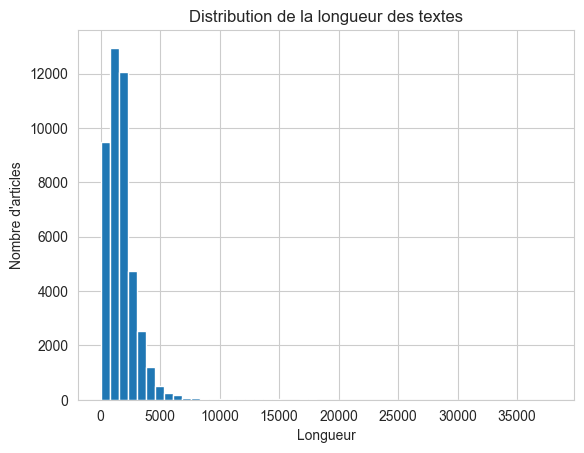

In [3]:
# Distribution des labels
print(df['label'].value_counts())

# Description rapide
df.describe()

# Longueur des textes
df['text_length'] = df['processed_text'].apply(len)
df['text_length'].hist(bins=50)
plt.title("Distribution de la longueur des textes")
plt.xlabel("Longueur")
plt.ylabel("Nombre d'articles")
plt.show()

## Nuage de mots

* Visualisation : Word Cloud

On visualise les mots les plus fréquents dans l'ensemble du dataset.

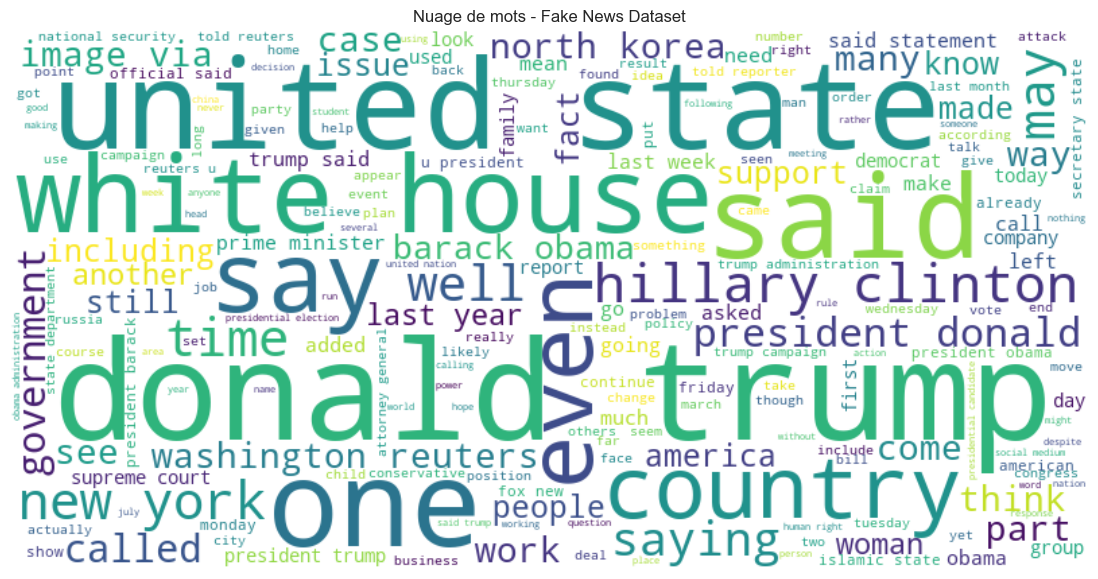

In [4]:
text_all = ' '.join(df['processed_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_all)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Nuage de mots - Fake News Dataset")
plt.show()

## Préparation des données pour les modèles
On sépare les features (X) et la cible (y), puis on divise en train/test.

In [5]:
X = df['processed_text']
y = df['label']

# Split train/test (pour notebook on peut sous-échantillonner pour gagner du temps)
X_train, X_test, y_train, y_test = train_test_split(
    X.sample(10000, random_state=42),  # sous-échantillon
    y.loc[X.sample(10000, random_state=42).index],
    test_size=0.2, random_state=42
)

print(f"Train set: {len(X_train)} | Test set: {len(X_test)}")

# TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Train set: 8000 | Test set: 2000


## Entraînement et évaluation : 


* Modèle 1 : Random Forest

On entraîne un modèle Random Forest et on évalue sa performance.

RandomForest Accuracy: 0.993
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1020

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



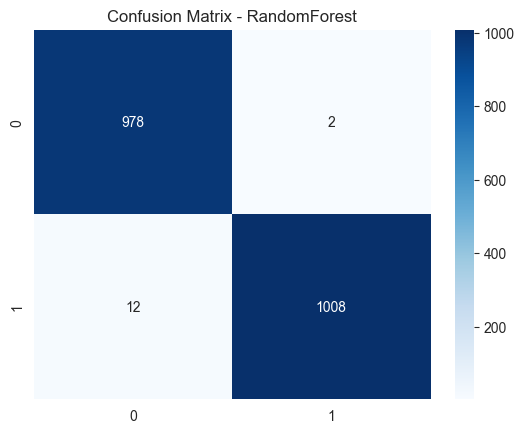

['../models/tfidf_vectorizer.pkl']

In [6]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_vec, y_train)

rf_pred = rf_model.predict(X_test_vec)
print("RandomForest Accuracy:", accuracy_score(y_test, rf_pred))
print(classification_report(y_test, rf_pred))

# Confusion Matrix
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - RandomForest")
plt.show()

# Sauvegarde
os.makedirs("../models", exist_ok=True)
joblib.dump(rf_model, "../models/rf_model.pkl")
joblib.dump(vectorizer, "../models/tfidf_vectorizer.pkl")

* Modèle 2 : XGBoost

On entraîne un modèle XGBoost et on compare avec Random Forest.

c:\Users\loulouu\FakeNewsDetection\venv\Lib\site-packages\xgboost\training.py:200: UserWarning: [00:23:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.993
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      0.99      0.99      1020

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000



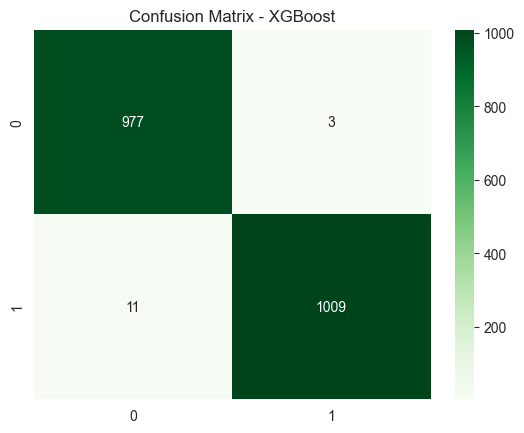

['../models/xgb_model.pkl']

In [7]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_vec, y_train)

xgb_pred = xgb_model.predict(X_test_vec)
print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred))

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - XGBoost")
plt.show()

# Sauvegarde
joblib.dump(xgb_model, "../models/xgb_model.pkl")

# Conclusion
- Les modèles Random Forest et XGBoost ont une très bonne précision (>99%) sur ce sous-échantillon.
- Le dataset est bien équilibré entre Fake News et Real News.
- Le modèle peut être utilisé pour prédire de nouvelles phrases après chargement du modèle et du TF-IDF vectorizer.